In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report, precision_score, f1_score

In [2]:
# Load the dataset
data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


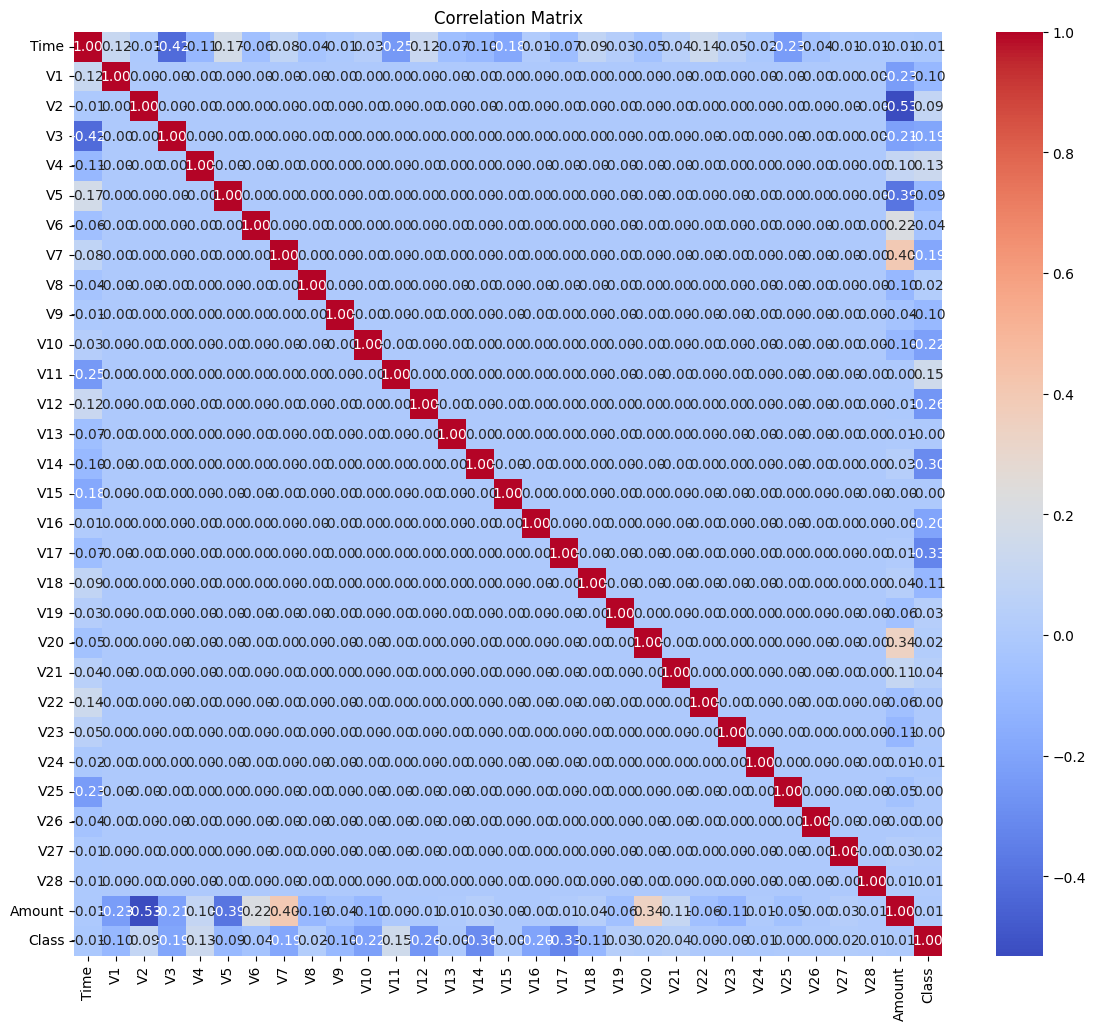

In [3]:
# Plot the correlation matrix
plt.figure(figsize=(14, 12))
corr = data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [4]:
# Normalize the 'Amount' column and drop 'Time' and 'Amount' columns
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time', 'Amount'], axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [5]:
# Separate features and target variable
X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']

In [6]:
# Number of data points in the minority class
number_records_fraud = len(data[data.Class == 1])
fraud_indices = np.array(data[data.Class == 1].index)

# Indices of the normal classes
normal_indices = data[data.Class == 0].index

# Randomly select the same number of normal transactions as fraud transactions
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace=False)
random_normal_indices = np.array(random_normal_indices)

# Concatenate the fraud indices with the randomly selected normal indices
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])

# Create the undersampled dataset
under_sample_data = data.iloc[under_sample_indices, :]

X_undersample = under_sample_data.loc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.loc[:, under_sample_data.columns == 'Class']

# Display the class distribution in the undersampled dataset
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.Class == 0]) / len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.Class == 1]) / len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  984


In [7]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number of transactions in the training dataset: ", len(X_train))
print("Number of transactions in the test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train) + len(X_test))

Number of transactions in the training dataset:  199364
Number of transactions in the test dataset:  85443
Total number of transactions:  284807


In [8]:
# Split the undersampled data into training and test sets
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(
    X_undersample, y_undersample, test_size=0.3, random_state=0)

print("Number of transactions in the undersampled training dataset: ", len(X_train_undersample))
print("Number of transactions in the undersampled test dataset: ", len(X_test_undersample))
print("Total number of transactions: ", len(X_train_undersample) + len(X_test_undersample))

Number of transactions in the undersampled training dataset:  688
Number of transactions in the undersampled test dataset:  296
Total number of transactions:  984


In [9]:
# Train Logistic Regression model
lr = LogisticRegression(C=0.01, penalty='l1', solver='liblinear')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())

LogisticRegression(C=0.01, penalty='l1', solver='liblinear')

In [10]:
# Predict on the test set
y_pred = lr.predict(X_test.values)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


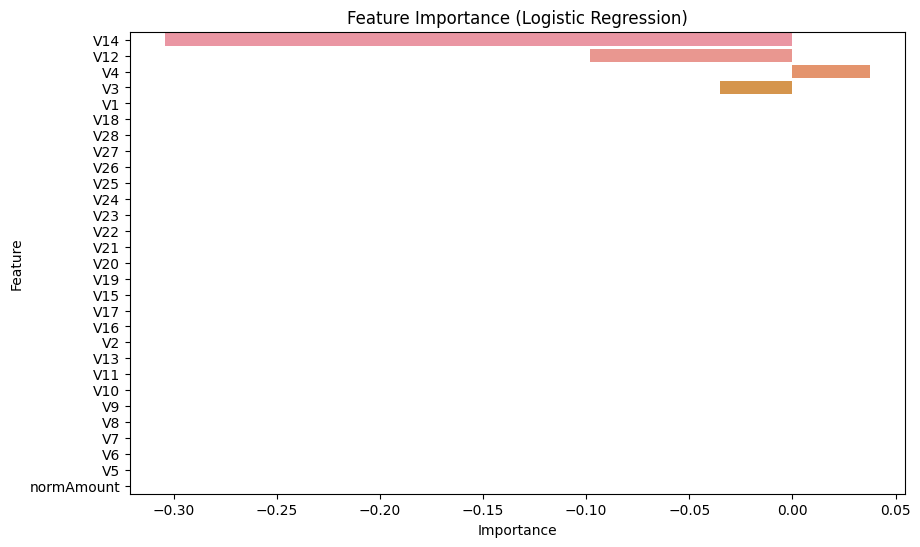

In [11]:
# Get the coefficients of the features
coefficients = lr.coef_[0]
features = X_train_undersample.columns

# Plot feature importance
feature_importance = pd.DataFrame({'Feature': features, 'Importance': coefficients})
feature_importance = feature_importance.sort_values(by='Importance', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance (Logistic Regression)')
plt.show()

In [12]:
# Confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print("Recall metric in the testing dataset: ", cnf_matrix[1, 1] / (cnf_matrix[1, 0] + cnf_matrix[1, 1]))

Recall metric in the testing dataset:  0.9183673469387755


Text(0.5, 1.0, 'Confusion Matrix')

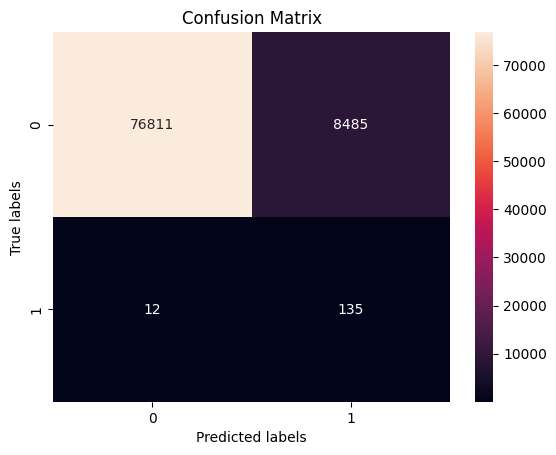

In [13]:
# Plot confusion matrix
ax = plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


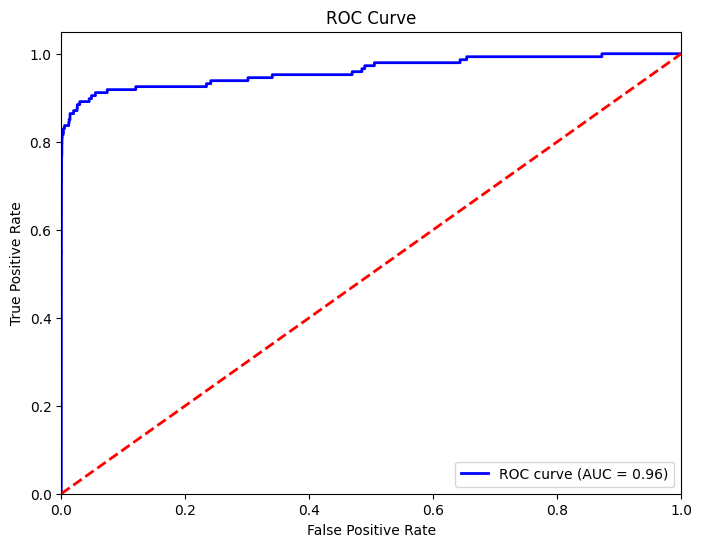

In [14]:
# Predict probabilities
y_pred_proba = lr.predict_proba(X_test.values)[:, 1]

# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

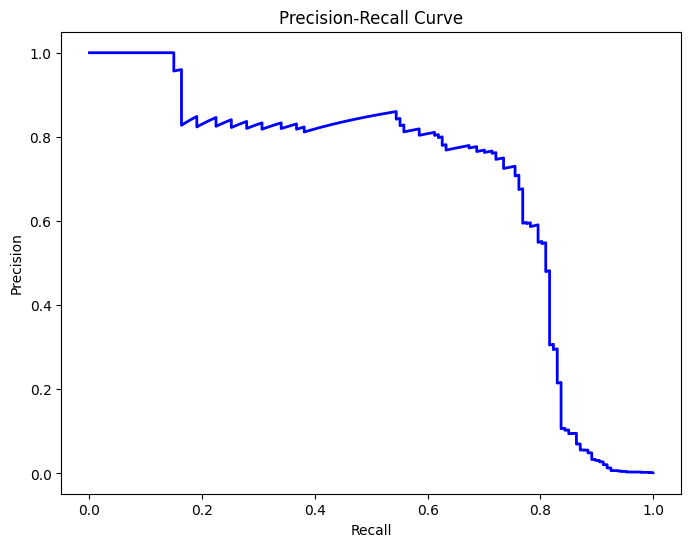

In [15]:
# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [16]:
# Classification report
print(classification_report(y_test, y_pred))

# AUC metric
print(f'AUC: {roc_auc:.2f}')

# Compute precision, recall, and F1-score
precision_score_val = precision_score(y_test, y_pred)
recall_score_val = recall_score(y_test, y_pred)
f1_score_val = f1_score(y_test, y_pred)

print(f'Precision: {precision_score_val:.2f}')
print(f'Recall: {recall_score_val:.2f}')
print(f'F1-Score: {f1_score_val:.2f}')

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     85296
           1       0.02      0.92      0.03       147

    accuracy                           0.90     85443
   macro avg       0.51      0.91      0.49     85443
weighted avg       1.00      0.90      0.95     85443

AUC: 0.96
Precision: 0.02
Recall: 0.92
F1-Score: 0.03
